<a href="https://www.kaggle.com/code/leannelin/loan-default-predictor-xgboost-and-neural-network?scriptVersionId=185984222" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read in the data set
df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [4]:
df.shape

(32581, 12)

In [5]:
df.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


# **EDA**

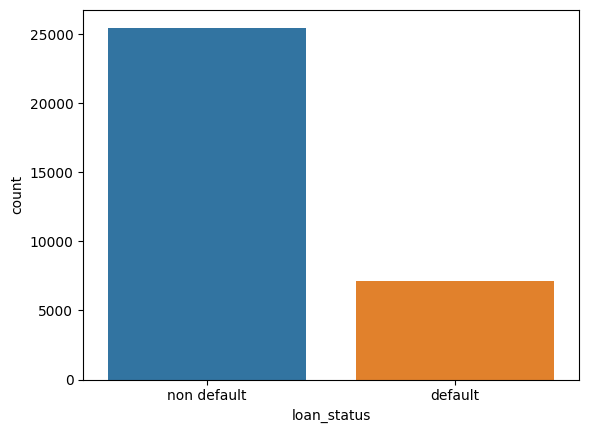

In [8]:
#view the count of non default loans and default loans
ax=sns.countplot(x='loan_status', data=df); # Loan status (0 is non default, 1 is default)
ax.set_xticklabels(['non default', 'default'])
plt.show()

In [9]:
# view the percentage break down of loan_status
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

We can see that the data set contains 78% of non defaults and 22% of defaults. This will be useful as a baseline when we evaluate our models.

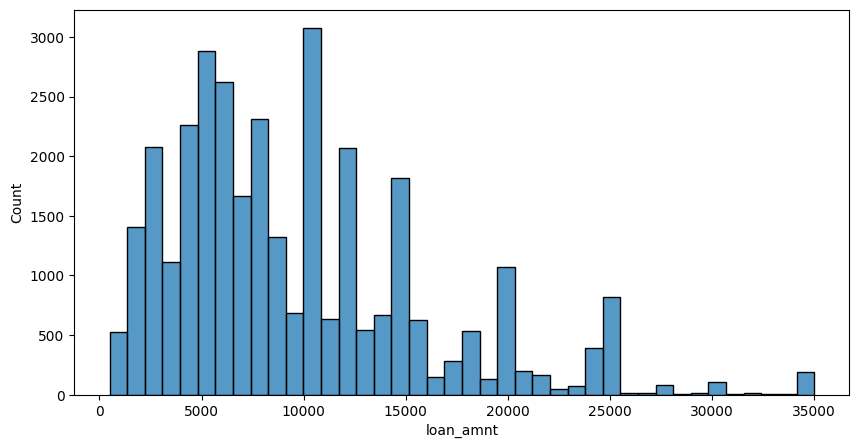

In [10]:
# view the count of loan amounts (we'll see that the majority of loans in the data set are up to $20,000)
plt.figure(figsize=(10,5))
sns.histplot(df['loan_amnt'],kde=False, bins=40);

In [11]:
#view the correlation between all continuous numeric variables
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
corr_matrix

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.021629,-0.042411,0.859133
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.144449,-0.254471,0.117987
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.082489,-0.054111,0.144699
loan_amnt,0.050787,0.266820,0.113082,1.000000,0.146813,0.105376,0.572612,0.041967
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.335133,0.120314,0.016696
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.015529,-0.031690,1.000000


<Axes: >

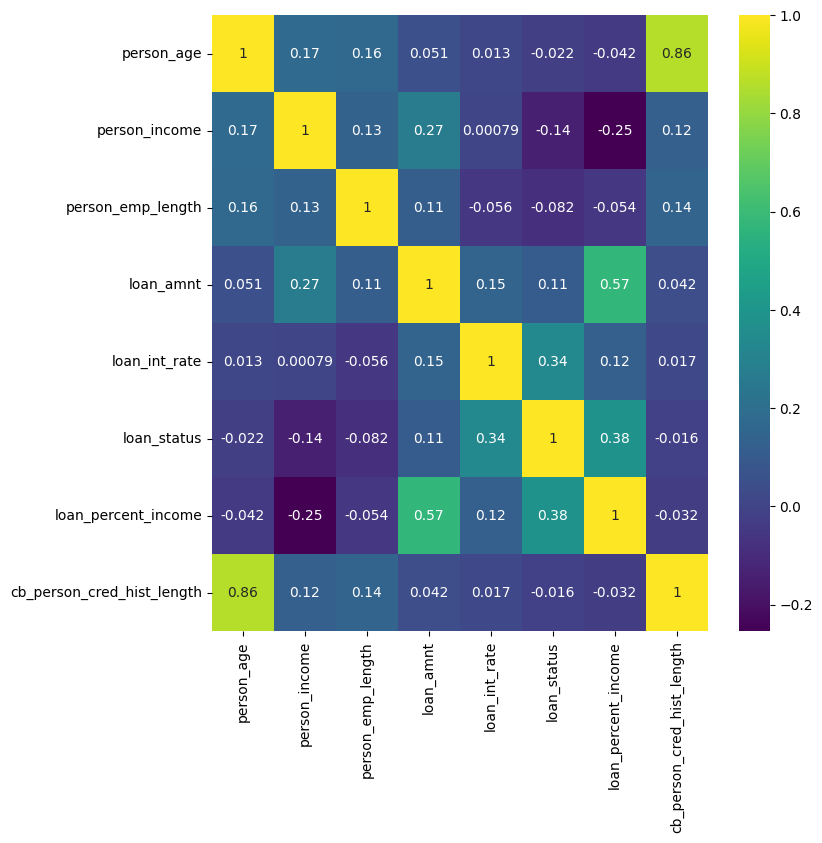

In [12]:
#visualise the correlation heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

points of interest regarding correlation:

strong positive correlation between person_age and cb_person_cred_hist_length
positive correlation between loan_status and loan_int_rate
positive correlation between loan_status and loan_percent_income
positive correlation between loan_amnt and loan_percent_income

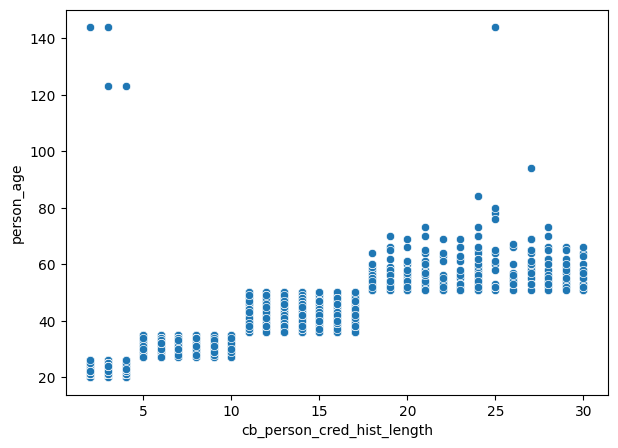

In [13]:
#view the correlation between person_age and cb_person_cred_hist_length as a scatterplot
plt.figure(figsize=(7,5))
sns.scatterplot(x='cb_person_cred_hist_length', y='person_age', data=df);

We can see that there are some outliers in person_age with some data points at 120+ years old. The strong correlation between these two variables makes sense as we expect that the history length of an applicant increases with age. i.e. the older the person, the longer their credit history.

In [14]:
df['person_age'].min()

20

In [15]:
df['person_age'].max()

144

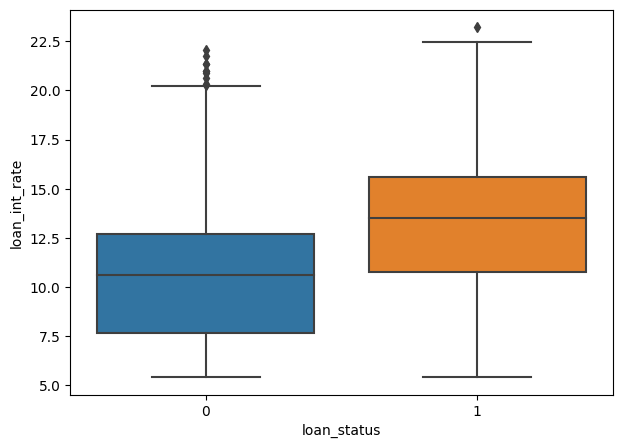

In [16]:
#view the correlation between person_age and cb_person_cred_hist_length as a boxplot
plt.figure(figsize=(7,5))
sns.boxplot(x='loan_status', y='loan_int_rate', data=df);

We can see that most non default loans are in the 7.5-12.5% interest rate range, with some loans over 20% interest. The default loans have a slighter higher interest rate.

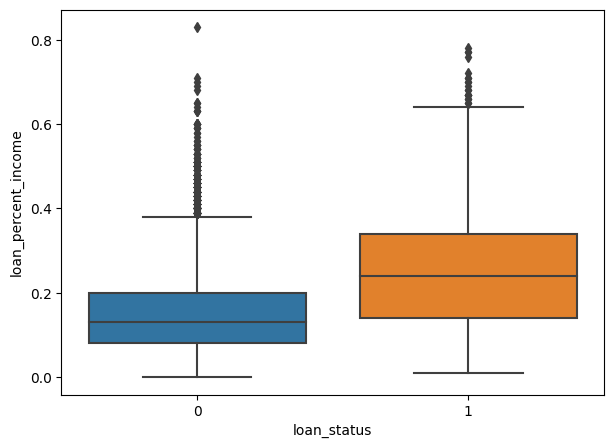

In [17]:
#view the correlation between loan_status and loan_percent_income as a boxplot
plt.figure(figsize=(7,5))
sns.boxplot(x='loan_status', y='loan_percent_income', data=df);

The non default loans have a lower loan to income percentage, as expected, however, there are also some data points as higher loan to income percentages.

The default loans have data points at slighter higher loan to income percentage and the range of these percentages is larger than non default loans.


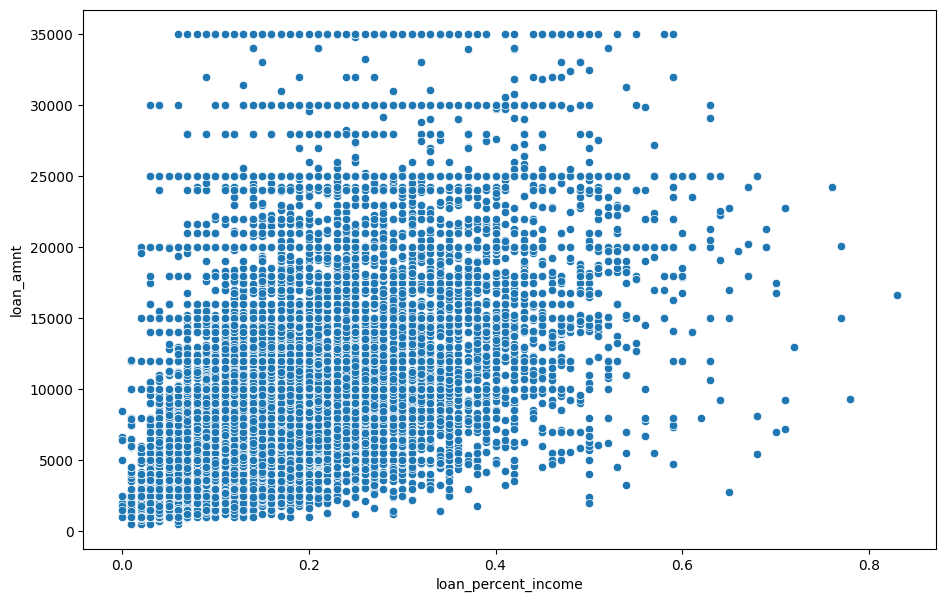

In [18]:
#view the correlation between loan_amnt and loan_percent_income as a boxplot
plt.figure(figsize=(11,7))
sns.scatterplot(x='loan_percent_income', y='loan_amnt', data=df);

For this data set, loan amounts are up to 35,000 and the loan to income percentage is below 90%.
The majority of the data points lie within loan amount of 25,000 and loan to income percentage of 50%.
The positive correlation between these features means that as the loan amount increases, this tends to mean the applicant is borrowing an increasing percentage of their income.

I expected a stronger positive correlation between loan_int_rate and loan_percent_income, as it would be expected that as the loan to income percentage increases, credit risk would increase and hence the loan interest rate would increase accordingly.

In [19]:
df['loan_int_rate'].groupby(df['loan_percent_income']).describe().transpose()

loan_percent_income,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.67,0.68,0.69,0.70,0.71,0.72,0.76,0.77,0.78,0.83
count,8.000000,128.000000,332.000000,693.000000,899.000000,1080.000000,1161.000000,1255.000000,1309.000000,1254.000000,...,4.000000,3.0000,2.000000,3.000000,3.000000,1.00,1.00,2.000000,1.00,1.00
mean,10.000000,10.174922,10.444127,10.728975,10.707152,10.504065,10.487674,10.397211,10.544752,10.583349,...,13.407500,10.7500,11.520000,13.796667,8.243333,7.88,11.12,9.700000,8.38,9.76
std,2.518605,2.831873,3.184800,3.178323,3.214128,3.296869,3.308970,3.100576,3.211495,3.224019,...,1.599445,3.3851,1.272792,1.423037,3.713022,NaN,NaN,0.084853,NaN,NaN
min,7.400000,5.420000,5.420000,5.420000,5.420000,5.420000,5.420000,5.420000,5.420000,5.420000,...,11.540000,7.7500,10.620000,12.210000,6.030000,7.88,11.12,9.640000,8.38,9.76
25%,7.662500,7.680000,7.505000,7.680000,7.680000,7.510000,7.510000,7.660000,7.510000,7.660000,...,12.342500,8.9150,11.070000,13.215000,6.100000,7.88,11.12,9.670000,8.38,9.76
50%,9.465000,9.910000,10.370000,10.750000,10.990000,10.590000,10.590000,10.380000,10.590000,10.650000,...,13.675000,10.0800,11.520000,14.220000,6.170000,7.88,11.12,9.700000,8.38,9.76
75%,12.400000,12.730000,13.060000,13.430000,13.060000,12.990000,12.990000,12.680000,13.110000,12.990000,...,14.740000,12.2500,11.970000,14.590000,9.350000,7.88,11.12,9.730000,8.38,9.76
max,13.480000,17.270000,19.910000,19.290000,20.690000,20.620000,22.480000,21.270000,20.990000,21.360000,...,14.740000,14.4200,12.420000,14.960000,12.530000,7.88,11.12,9.760000,8.38,9.76


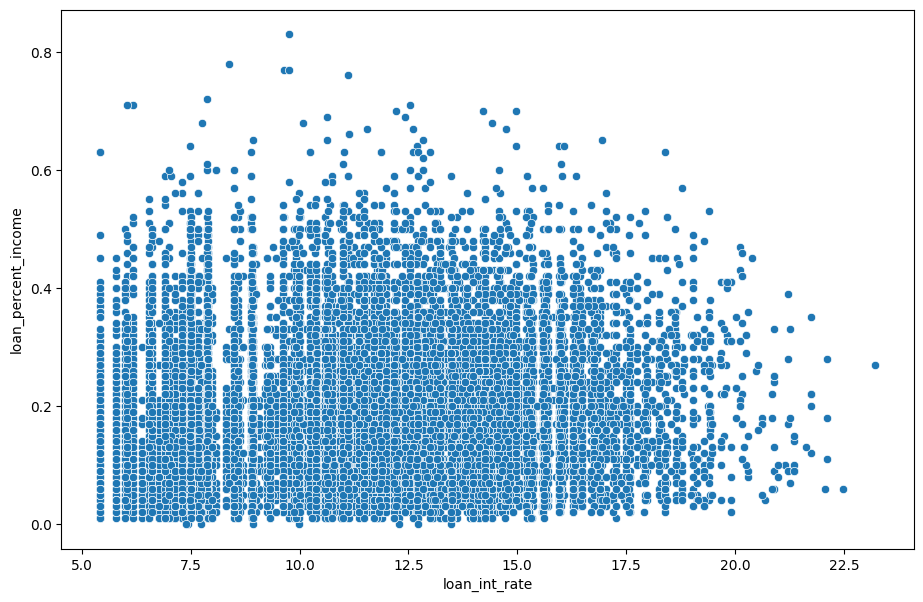

In [20]:
plt.figure(figsize=(11,7))
sns.scatterplot(x='loan_int_rate', y='loan_percent_income', data=df);

We can see that there is a lot of variability in the data points, we can take an average of the loan to income percentage to smooth out the data and visually highlight any trends.

In [21]:
# Calculate the average loan percentage to income by interest rate
rate_loan_percent = df.groupby('loan_int_rate')['loan_percent_income'].mean().reset_index()

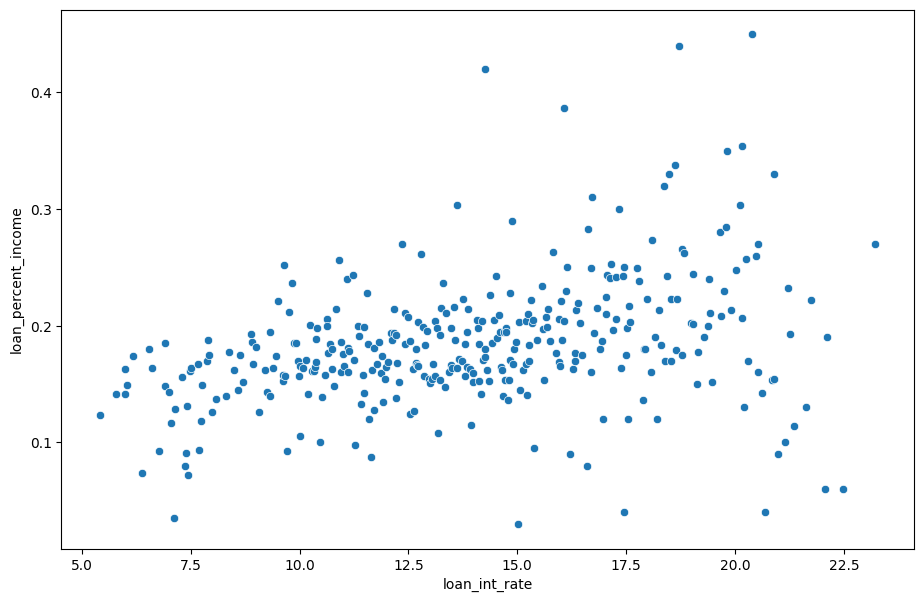

In [22]:
plt.figure(figsize=(11,7))
sns.scatterplot(x='loan_int_rate', y='loan_percent_income', data= rate_loan_percent);

We can now see that on average, as the loan to income percentage increases, the loan interest rate tends to increase. 

In [23]:
# Generate the correlation:
rate_loan_percent.corr()

,loan_int_rate,loan_percent_income
loan_int_rate,1.000000,0.351271
loan_percent_income,0.351271,1.000000


There is a clear positive correlation, but at this stage, it may be too early to drop any data points by smoothing the loan to income percentage.
We may revisit the average loan to income percentage by interest rate later once we have evaluated the model.

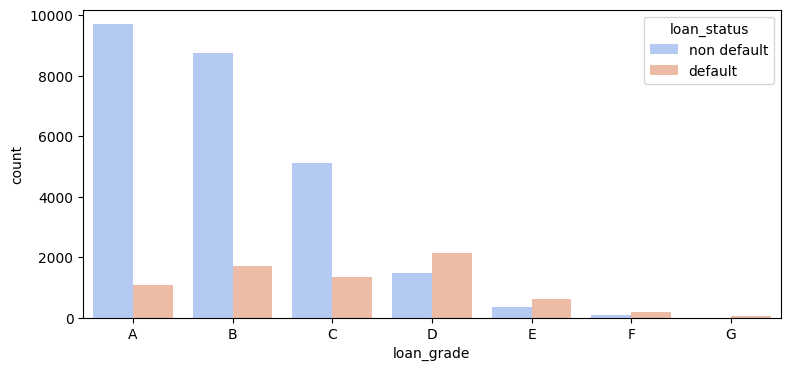

In [24]:
# visualise the number of non default and default loans by loan grade
plt.figure(figsize=(9,4))
ax =sns.countplot(x='loan_grade', data = df, order=sorted(df['loan_grade'].unique()), 
              hue='loan_status', palette='coolwarm');

# Set the legend labels to 'non default' and 'default'
new_labels = ['non default', 'default']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.show()

Interestingly most defaults are in grades A - D.

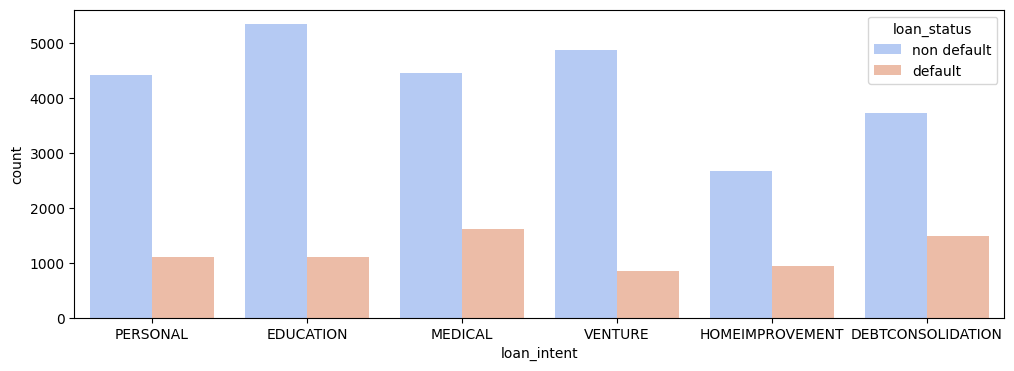

In [25]:
# visualise the loan purpose by non default and default loans

plt.figure(figsize=(12,4))
ax =sns.countplot(x='loan_intent', data = df, hue='loan_status', palette='coolwarm');

# Set the legend labels to 'non default' and 'default'
new_labels = ['non default', 'default']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.show()

We can see that defaults are relatively consistent across the loan purposes.

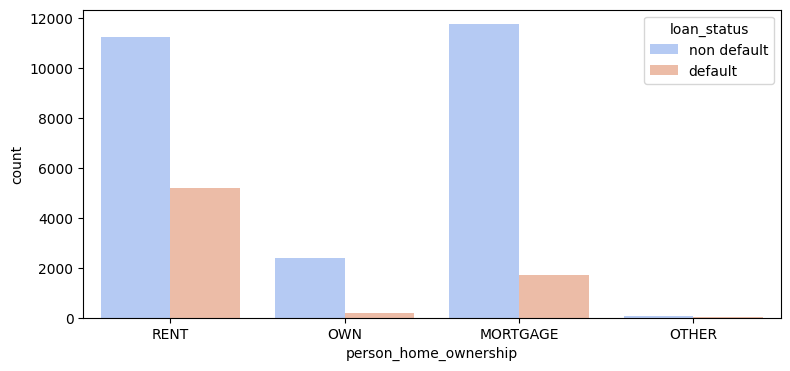

In [26]:
# visualise home owernship status by non default and default loans

plt.figure(figsize=(9,4))
ax =sns.countplot(x='person_home_ownership', data = df, hue='loan_status', palette='coolwarm');

# Set the legend labels to 'non default' and 'default'
new_labels = ['non default', 'default']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.show()

This graph tells us that the majority of loan defaults are renters.

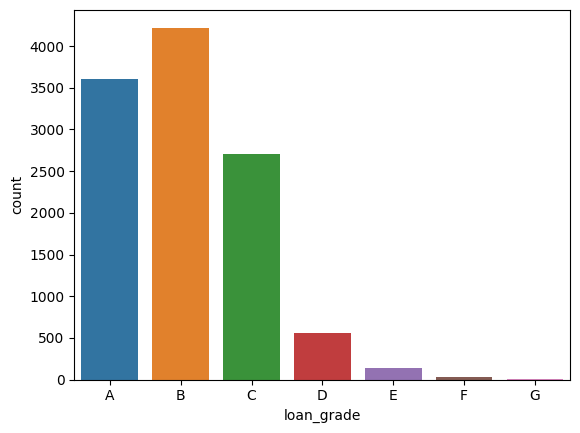

In [27]:
# Filter the dataframe where person_home_ownership is 'RENT' and loan defaulted
rent_defaulted_df = df[(df['person_home_ownership'] == 'RENT')&(df['loan_status']==0)]

# View the loan_grade for the filtered dataframe
sns.countplot(x='loan_grade', order=sorted(df['loan_grade'].unique()), data=rent_defaulted_df);

In [28]:
loan_grade_counts = rent_defaulted_df['loan_grade'].value_counts()

# Calculate the percentage of each loan grade
loan_grade_percentages = (loan_grade_counts / len(rent_defaulted_df)) * 100

# Convert to a DataFrame for better readability 
loan_grade_percentages_df = loan_grade_percentages.reset_index()
loan_grade_percentages_df.columns = ['loan_grade', 'percentage']

# Display the percentages
loan_grade_percentages_df

,loan_grade,percentage
0,B,37.515550
1,A,32.006398
2,C,24.080327
3,D,4.922694
4,E,1.217345
5,F,0.248800
6,G,0.008886


Interestingly, approx 83% of renters who default have a loan grade of A, B, or C.

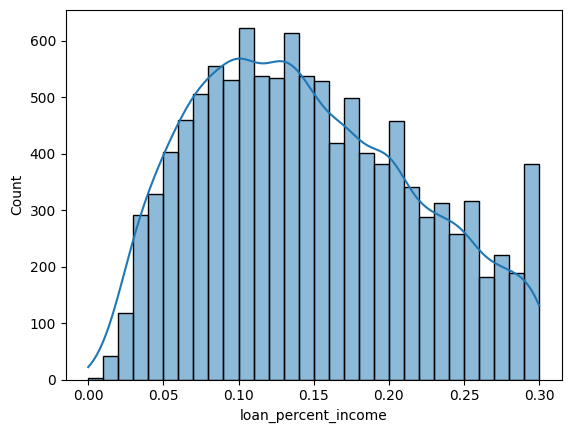

In [29]:
#visualise the renters who default by the loan to income percentage
sns.histplot(rent_defaulted_df['loan_percent_income'], kde=True, bins=30);

In [30]:
# Let's see if the renters who default also have a previous default on their credit file?
rent_defaulted_df['cb_person_default_on_file'].value_counts(normalize=True)

cb_person_default_on_file
N    0.845211
Y    0.154789
Name: proportion, dtype: float64

Interestingly, 84% of renters who default have no prior defaults on file.

<Axes: xlabel='cb_person_cred_hist_length', ylabel='count'>

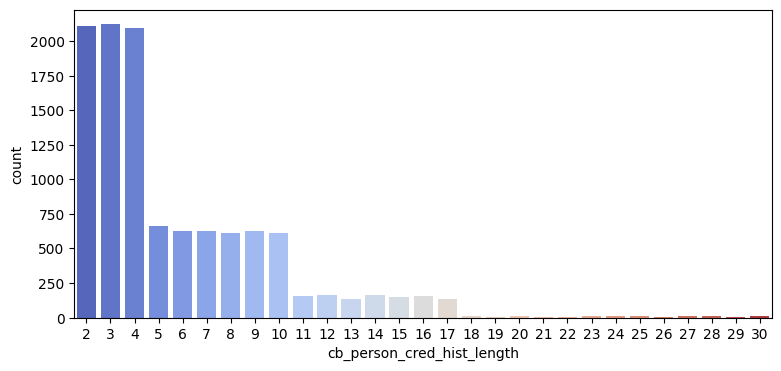

In [31]:
# visualise the credit history length of renters who also defaulted
plt.figure(figsize=(9,4))
sns.countplot(x='cb_person_cred_hist_length', data=rent_defaulted_df, palette='coolwarm')

In [32]:
rent_defaulted_df['cb_person_cred_hist_length'].value_counts(normalize=True)

cb_person_cred_hist_length
3     0.188555
2     0.187133
4     0.185889
5     0.059090
7     0.055802
6     0.055625
9     0.055536
8     0.054558
10    0.054470
14    0.014395
12    0.014306
11    0.013951
16    0.013684
15    0.013329
13    0.012262
17    0.011996
24    0.001066
28    0.000977
23    0.000889
25    0.000800
30    0.000800
27    0.000800
18    0.000711
20    0.000711
19    0.000622
26    0.000622
21    0.000533
22    0.000533
29    0.000355
Name: proportion, dtype: float64

Almost 60% of renters who default, have a credit history length of 4 years or less. Extra credit worthiness checks should be done by loan writers in order to reduce the number of loan defaults.

# **Data Preprocessing**

Objective: remove or fill in any missing data. Remove unnecessary or repetitive features. Convert categorical features to dummy variables.

In [33]:
df.shape

(32581, 12)

### Handling missing data

In [34]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [35]:
df['person_emp_length'].value_counts(dropna=False)

person_emp_length
0.0      4105
2.0      3849
3.0      3456
5.0      2946
1.0      2915
4.0      2874
6.0      2666
7.0      2196
8.0      1687
9.0      1367
NaN       895
11.0      740
10.0      696
12.0      575
13.0      426
14.0      335
15.0      238
16.0      165
17.0      129
18.0      104
19.0       64
20.0       42
21.0       38
22.0       19
24.0       10
23.0       10
25.0        8
26.0        6
27.0        5
31.0        4
28.0        3
123.0       2
30.0        2
41.0        1
34.0        1
29.0        1
38.0        1
Name: count, dtype: int64

In [36]:
# Calculate the mean of 'person_emp_length' excluding the values 123
mean_emp_length = df[df['person_emp_length'] != 123]['person_emp_length'].mean()
mean_emp_length 

4.782224466607752

In [37]:
# Calculate the median of 'person_emp_length' excluding the values 123
median_emp_length = df[df['person_emp_length'] != 123]['person_emp_length'].median()
median_emp_length 

4.0

As the feature values of person_emp_length are integers, the median is a better value than the mean to fill in Nan.

In [38]:
# Fill in Nan with the median employment length
df['person_emp_length'] = df['person_emp_length'].fillna(median_emp_length)
df['person_emp_length'].value_counts(dropna=False)

person_emp_length
0.0      4105
2.0      3849
4.0      3769
3.0      3456
5.0      2946
1.0      2915
6.0      2666
7.0      2196
8.0      1687
9.0      1367
11.0      740
10.0      696
12.0      575
13.0      426
14.0      335
15.0      238
16.0      165
17.0      129
18.0      104
19.0       64
20.0       42
21.0       38
22.0       19
24.0       10
23.0       10
25.0        8
26.0        6
27.0        5
31.0        4
28.0        3
123.0       2
30.0        2
41.0        1
34.0        1
29.0        1
38.0        1
Name: count, dtype: int64

In [39]:
# Replace values equal to 123 with the median_emp_length
df['person_emp_length']= df['person_emp_length'].replace({123: median_emp_length})

# Verify the changes
df['person_emp_length'].value_counts(dropna=False)

person_emp_length
0.0     4105
2.0     3849
4.0     3771
3.0     3456
5.0     2946
1.0     2915
6.0     2666
7.0     2196
8.0     1687
9.0     1367
11.0     740
10.0     696
12.0     575
13.0     426
14.0     335
15.0     238
16.0     165
17.0     129
18.0     104
19.0      64
20.0      42
21.0      38
22.0      19
23.0      10
24.0      10
25.0       8
26.0       6
27.0       5
31.0       4
28.0       3
30.0       2
41.0       1
34.0       1
29.0       1
38.0       1
Name: count, dtype: int64

In [40]:
df['loan_int_rate'].value_counts(dropna=False)

loan_int_rate
NaN      3116
7.51      756
10.99     749
7.49      645
7.88      642
         ... 
21.64       1
20.48       1
17.46       1
21.14       1
20.53       1
Name: count, Length: 349, dtype: int64

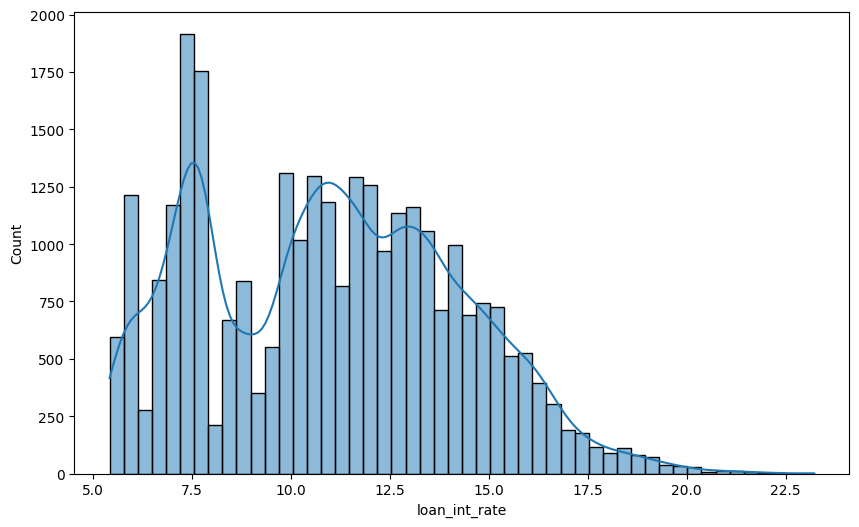

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_int_rate'], kde=True);

In [42]:
df['loan_int_rate'].mean()

11.011694892245036

In [43]:
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].mean())
df['loan_int_rate'].value_counts(dropna=False)

loan_int_rate
11.011695    3116
7.510000      756
10.990000     749
7.490000      645
7.880000      642
             ... 
21.640000       1
20.480000       1
17.460000       1
21.140000       1
20.530000       1
Name: count, Length: 349, dtype: int64

<Axes: xlabel='loan_int_rate', ylabel='Count'>

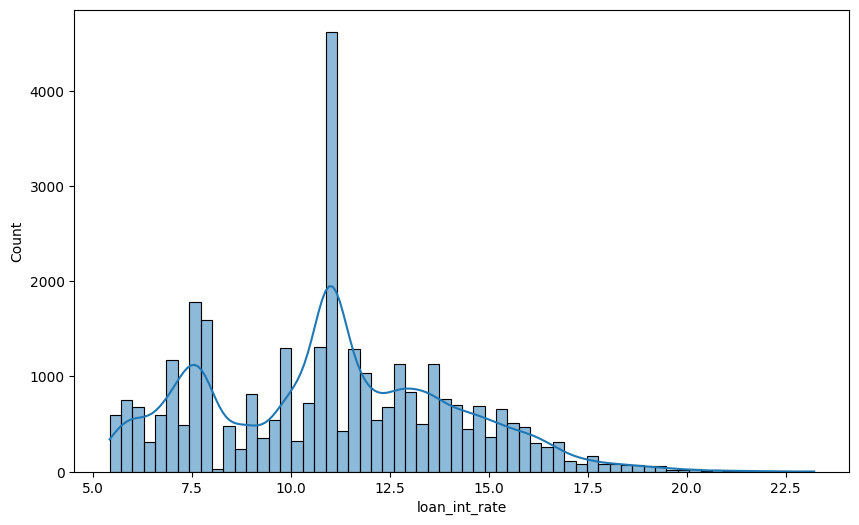

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_int_rate'], kde=True)

The NaN values for 'loan_int_rate' were filled with the average 'loan_int_rate' - this may need to be reviewed later.

In [45]:
# check that there are no NaN values 
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### Handling categorial variables and dummy variables

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [47]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64

In [48]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

In [49]:
df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64

In [50]:
#convert the above features to dummy variables
dummies_list=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

In [51]:
dummies = pd.get_dummies(df[dummies_list], drop_first=True)

df = pd.concat([df.drop(dummies_list,axis=1),dummies], axis=1)

In [52]:
# convert the loan grade feature into dummy variables whilst retaining the ranking of the grades
df['loan_grade'].value_counts()

loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

In [53]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Define the order of categories
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

#Convert the loan_grade to ordinal values using OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[grades])
df['loan_grade_ordinal'] = ordinal_encoder.fit_transform(df[['loan_grade']])

In [54]:
#Convert ordinal values to dummy variables using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
loan_grade_dummies = onehot_encoder.fit_transform(df[['loan_grade_ordinal']])

In [55]:
#Create a DataFrame for the dummy variables
loan_grade_dummies_df = pd.DataFrame(loan_grade_dummies, columns=[f'grade_{int(i)}' 
            for i in range(loan_grade_dummies.shape[1])])

In [56]:
# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, loan_grade_dummies_df], axis=1)

In [57]:
# Drop the original and ordinal loan_grade columns as they are no longer needed
df.drop(['loan_grade', 'loan_grade_ordinal'], axis=1, inplace=True)

### Handling outliers

In [58]:
age_above_80 = df[df['person_age'] > 80]
age_above_80

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,grade_0,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6
81,144,250000,4.0,4800,13.570000,0,0.02,3,False,False,...,False,True,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
183,144,200000,4.0,6000,11.860000,0,0.03,2,False,False,...,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
575,123,80004,2.0,20400,10.250000,0,0.25,3,False,False,...,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
747,123,78000,7.0,20000,11.011695,0,0.26,4,False,False,...,False,True,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32297,144,6000000,12.0,5000,12.730000,0,0.00,25,False,False,...,True,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32416,94,24000,1.0,6500,11.011695,0,0.27,27,False,False,...,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32506,84,94800,2.0,10000,7.510000,0,0.11,24,False,False,...,True,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Filter out rows where person_age > 80 and assign the result back to df
df = df[df['person_age'] <= 80]

In [60]:
df['person_age'].max()

80

In [61]:
# final review of missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32574 entries, 0 to 32580
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32574 non-null  int64  
 1   person_income                32574 non-null  int64  
 2   person_emp_length            32574 non-null  float64
 3   loan_amnt                    32574 non-null  int64  
 4   loan_int_rate                32574 non-null  float64
 5   loan_status                  32574 non-null  int64  
 6   loan_percent_income          32574 non-null  float64
 7   cb_person_cred_hist_length   32574 non-null  int64  
 8   person_home_ownership_OTHER  32574 non-null  bool   
 9   person_home_ownership_OWN    32574 non-null  bool   
 10  person_home_ownership_RENT   32574 non-null  bool   
 11  loan_intent_EDUCATION        32574 non-null  bool   
 12  loan_intent_HOMEIMPROVEMENT  32574 non-null  bool   
 13  loan_intent_MEDICAL  

# **Train Test Split**

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
# Set X and y variables to the .values of the features and label

X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [64]:
# Perform a train/test split with test_size=0.2 and a random_state of 101
# We will use stratified sampling to ensure that the model sees a representative distribution of classes during training and testing, 
#    which is especially important in imbalanced datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

# **Normalize the data**

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Training classification models**

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [68]:
lr = LogisticRegression()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier(verbose=False)
cat = CatBoostClassifier(verbose=0)
lgb = LGBMClassifier(verbose=0)

In [69]:
clf = {
    'logreg': lr,
    'KN' : knc, 
    'xgb':xgb,
    'cat':cat,
    'lgb':lgb
}

In [70]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, f1_score, classification_report

In [71]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate confusion matrix to get TN and FP for specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    return accuracy, precision, recall, f1, specificity

In [72]:
accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []

for name, model in clf.items():
    try:
        current_accuracy, current_precision, current_recall, current_f1, current_specificity= train_classifier(model, X_train, y_train, X_test, y_test)

        print("Model: ", name)
        print("Accuracy: ", current_accuracy)
        print("Precision: ", current_precision)
        print("Recall: ", current_recall)
        print("F1 Score: ", current_f1)
        print("Specificity: ", current_specificity)
        print()

        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        recall_scores.append(current_recall)
        f1_scores.append(current_f1)
        specificity_scores.append(current_specificity)
        
    except Exception as e:
        print(f"Error with model {name}: {e}")

Model:  logreg
Accuracy:  0.8658480429777436
Precision:  0.774
Recall:  0.5443037974683544
F1 Score:  0.639141205615194
Specificity:  0.955625368152366

Model:  KN
Accuracy:  0.8947045280122794
Precision:  0.859375
Recall:  0.6188466947960619
F1 Score:  0.7195421095666393
Specificity:  0.971725898291773

Model:  xgb
Accuracy:  0.9323100537221796
Precision:  0.9414941494149415
Recall:  0.7355836849507735
F1 Score:  0.8258981444926965
Specificity:  0.987237384645592

Model:  cat
Accuracy:  0.9338449731389102
Precision:  0.9635173058933583
Recall:  0.7243319268635724
F1 Score:  0.8269771176234445
Specificity:  0.9923424307873552

Model:  lgb
Accuracy:  0.9324635456638527
Precision:  0.9685114503816794
Recall:  0.7137834036568214
F1 Score:  0.8218623481781376
Specificity:  0.9935205183585313



We need to take into consideration that the target variable loan_status was imbalanced (78% non defaults vs 22% defaults), therefore, accuracy (total correct predictions/total predictions) would not be a good measure of model performance.

Precision (correct positive predictions/total positive predictions) measures how well the model predicts non defaults i.e. of all the non defaults predicted, how many were actually non defaults.

Recall (correct positive predictions/all positive labels) measures how well the model can find all the non defaulters, the goal being to find the most number of non defaulters i.e of all the non default classes, how many were correctly identified as non default.

F1 Score measure how good and complete are the predictions (harmonic mean of precision and recall).

Specificity measures the model's ability to predict a true negative (i.e. defaulters who are actually defaulters)

In the context of using this model for new loan applicants and predicting whether the applicant will be a non defaulter or a defaulter:

* high precision means the model will miss some non defaulters but will have high accuracy of the non defaulters predicted, i.e. the non defaulters predicted will actually be non defaulters
* high recall means some defaulters will slip through the application process (model will predict them as non defaulters) but the model will capture most of the non defaulters.
* The preferred evaluation metric(s) will depend on the company's business strategy and goals. A focus on precision may be a conservative approach and the company could miss out on market share for the sake of high precision. For the purpose of this exercise, we will assume that we would like to maximise recall so that the model will capture most non defaulters in the application process (albeit some defaulters will slip through).

# **Optimize XGBoost using Cross Validation and GridSearch**

In [73]:
# So far, XGBoost has returned the highest recall so we will attempt to optimize this model.

In [74]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
# Instantiate the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', seed=123)

When we have imbalanced data, the XGBoost manual recommends to balance the positive and negative weights via scale_pos_weight and use AUC to measure overall model performance.

In [77]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
}

In [78]:
optimal_params = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose=2,
    n_jobs=10,
    cv=3
)

In [79]:
optimal_params.fit(X_train, y_train, verbose=False)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=2)

In [80]:
# Print best parameters found
print("Best parameters found: ", optimal_params.best_params_)

Best parameters found:  {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [81]:
best_score = optimal_params.best_score_
print("Best ROC AUC score: ", best_score)

Best ROC AUC score:  0.9379056514136446


# **Build final XGBoost model**

In [82]:
clf_xgb = XGBClassifier(objective='binary:logistic',
                       gamma=0.25,
                       learning_rate=0.1,
                       max_depth=5,
                       reg_lambda=0,
                       scale_pos_weight=1)

In [83]:
clf_xgb.fit(X_train,y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# **Evaluate XGBoost model**

In [84]:
# view confusion matrix

from sklearn import metrics

pd.DataFrame(
    metrics.confusion_matrix(y_test, clf_xgb.predict(X_test)),
    columns=['Predicted 0', 'Predicted 1'],
    index=['Actual 0', 'Actual 1']
)

,Predicted 0,Predicted 1
Actual 0,5041,52
Actual 1,408,1014


We can see that the model has captured almost all (approx 99%) of the non defaulters (as was our objective). However, approx. 28% of defaulters were predicted to be non defaulters. Whether or not this is an acceptable level of defaulters coming through as non defaulters and further tuning will depend on the business objectives of the financial institution.

In [85]:
# We can view the predicted probabilities on the test data
y_pred_prob_xgb = clf_xgb.predict_proba(X_test)*100

In [86]:
X_test.shape

(6515, 23)

In [87]:
pd.DataFrame(
    y_pred_prob_xgb,
    columns=['Probability non default', 'Probability default'],
)

,Probability non default,Probability default
0,79.844826,20.155174
1,93.425545,6.574456
2,92.154739,7.845262
3,96.235832,3.764173
4,87.255226,12.744774
...,...,...
6510,94.543449,5.456552
6511,99.859077,0.140921
6512,97.472595,2.527402
6513,97.985336,2.014662


# **Train a neural network with dropout layers and early stopping**

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

2024-06-29 00:26:05.442698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 00:26:05.442851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 00:26:05.602706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [89]:
X_train.shape

(26059, 23)

In [90]:
#train model with drop out layers and early stopping
seq = Sequential()

seq.add(Dense(23, activation='relu'))
seq.add(Dropout(0.2))

seq.add(Dense(12, activation='relu'))
seq.add(Dropout(0.2))

seq.add(Dense(6, activation='relu'))
seq.add(Dropout(0.2))

seq.add(Dense(units=1, activation='sigmoid'))

seq.compile(loss='binary_crossentropy', optimizer='adam')

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=25)

In [93]:
seq.fit(x=X_train, y=y_train, epochs=600, validation_data = (X_test,y_test),
         callbacks=[early_stop], verbose=False)

# **Evaluate neural network**

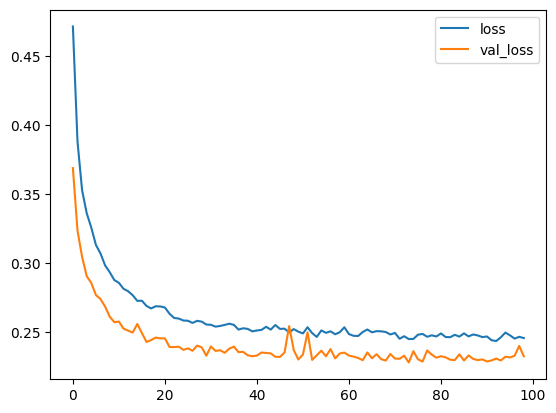

In [94]:
seq_loss = pd.DataFrame(seq.history.history)
seq_loss.plot();

In [95]:
predictions = (seq.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, predictions))

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5093
           1       0.98      0.66      0.79      1422

    accuracy                           0.92      6515
   macro avg       0.95      0.83      0.87      6515
weighted avg       0.93      0.92      0.92      6515



So far, the neural network seems to provide better recall than XGBoost.

In [96]:
# Make predictions on the test set
y_pred_prob = seq.predict(X_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    columns=['Predicted 0', 'Predicted 1'],
    index=['Actual 0', 'Actual 1']
)

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


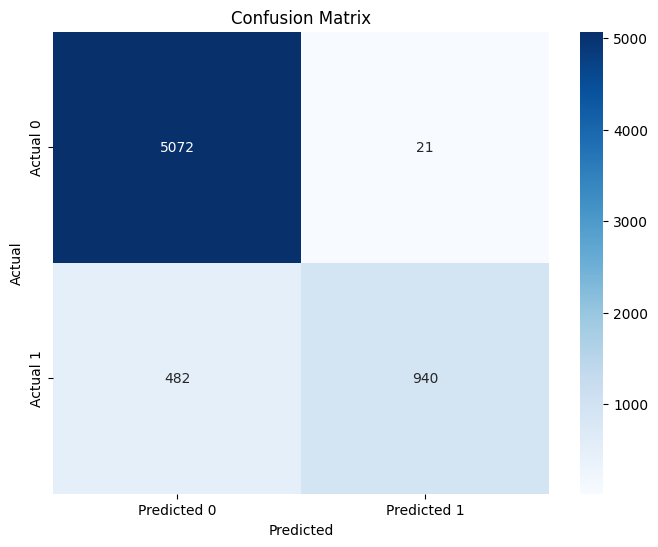

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can see that the neural network is even better than XGBoost at capturing the non defaulters, however, there was an increase to 31% of defaulters who are predicted as non defaulters (XGBoost was 28%).

In [98]:
# Given the customer below, would the neural network model predict this customer to be a non defaulter or a defaulter?

#generate a random customer from existing df
import random
random.seed(111)
random_ind = random.randint(0,len(df)-1)

new_customer = df.drop('loan_status',axis=1).iloc[random_ind]

# Convert boolean columns to integers
new_customer = new_customer.astype(float)

print(new_customer)

# Reshape new_customer data for prediction
new_customer_reshaped = new_customer.values.reshape(1,23).astype(np.float32)
new_customer_scaled = scaler.transform(new_customer_reshaped)

# Predict the probability of default
prediction_prob = seq.predict(new_customer_scaled)

#print(prediction_prob)

# Classify based on the threshold of 0.5
prediction_class = (prediction_prob > 0.5).astype('int64')

# Print the prediction
if prediction_class[0][0] == 1:
    print("The model predicts that the customer will default.")
else:
    print("The model predicts that the customer will not default.")

# Print the probability
print(f"Predicted probability of default: {prediction_prob[0][0]*100:0.2f}%")

person_age                         32.00
person_income                  123000.00
person_emp_length                  16.00
loan_amnt                       15200.00
loan_int_rate                      15.95
loan_percent_income                 0.12
cb_person_cred_hist_length          9.00
person_home_ownership_OTHER         0.00
person_home_ownership_OWN           0.00
person_home_ownership_RENT          0.00
loan_intent_EDUCATION               0.00
loan_intent_HOMEIMPROVEMENT         0.00
loan_intent_MEDICAL                 0.00
loan_intent_PERSONAL                0.00
loan_intent_VENTURE                 1.00
cb_person_default_on_file_Y         1.00
grade_0                             0.00
grade_1                             0.00
grade_2                             0.00
grade_3                             0.00
grade_4                             1.00
grade_5                             0.00
grade_6                             0.00
Name: 27108, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [99]:
# check if this customer actually defaulted or not (recall 0 = non default, 1 = default)
df.iloc[random_ind]['loan_status']

0